# Reconstructing even more features with PyGPlates

In this example, we will reconstruct data from the [Paleobiology Database (PBDB)](https://paleobiodb.org/#/). This data is in csv format. 


Import modules

In [1]:
import pandas as pd
import numpy as np
import pygplates
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import geopandas as gpd
from shapely.geometry.polygon import LinearRing, Point

## Download and import PBDB data

We can import data from the PBDB using the data url straight into [`pandas`](https://pandas.pydata.org/docs/reference/index.html#api). Alternatively, we can download the csv file from their [website](https://paleobiodb.org/classic/displayDownloadGenerator) and import that.

For importing csv files: it is often easier if the first row is the column name, although `pandas` does allow you to skip these header rows if needed.
Conveniently, the PBDB provides an option when downloading data to exclude the metadata at the beginning of the file. 

In [2]:
%%time
# ^ this is some cell magic! In this case, it will print out the cell execution time 

# download data for the Late Cretaceous, and inclue the paleoenvironment column.
# You can use the download page to play with the options and get the download link and/or CSV.
pbdb_data_url = 'https://paleobiodb.org/data1.2/occs/list.csv?max_ma=100&min_ma=66&show=coords,env'

## import from the URL
# pbdb_data = pd.read_csv(pbdb_data_url, sep=',') 

CPU times: user 1 µs, sys: 0 ns, total: 1 µs
Wall time: 2.15 µs


In [3]:
# import from the csv. This version has a number of columns deleted to make life a little easier

pbdb_data = pd.read_csv('Data/pbdb_data.csv', sep=',')

Let's take a look at what this dataframe contains

In [4]:
pbdb_data

,occurrence_no,accepted_name,max_ma,min_ma,reference_no,lng,lat,environment
0,14961,Nucula,72.1,66.0,40,-89.866669,37.000000,marine indet.
1,14962,Malletia,72.1,66.0,40,-89.866669,37.000000,marine indet.
2,14963,Nuculana,72.1,66.0,40,-89.866669,37.000000,marine indet.
3,14964,Nemodon,72.1,66.0,40,-89.866669,37.000000,marine indet.
4,14965,Striarca,72.1,66.0,40,-89.866669,37.000000,marine indet.
...,...,...,...,...,...,...,...,...
141067,1592861,Gryzmalia wukong,99.6,93.5,81545,96.720001,26.359167,terrestrial indet.
141068,1593120,Mytiloides labiatus,93.5,89.3,29214,-122.438911,39.555752,marine indet.
141069,1593200,Triceratops horridus,72.1,66.0,81555,-103.056000,44.713001,terrestrial indet.
141070,1593201,Triceratops,72.1,66.0,81556,-104.274002,43.666000,pond


That's a lot of points! `pandas` also makes it easy to check the columns in our data - which comes in handy if we have lots of columns.

Note that our coordinates are in their own 'lng' and 'lat' columns

In [5]:
pbdb_data.columns

Index(['occurrence_no', 'accepted_name', 'max_ma', 'min_ma', 'reference_no',
       'lng', 'lat', 'environment'],
      dtype='object')

For this example, we've also downloaded the fossil's environment. We can also check the unique environments in the pandas dataframe.

In [6]:
pbdb_data.environment.unique()

array(['marine indet.', nan, 'carbonate indet.', 'offshore',
       'basinal (carbonate)', 'foreshore', 'shoreface',
       'transition zone/lower shoreface', 'terrestrial indet.',
       'estuary/bay', 'coastal indet.', 'reef, buildup or bioherm',
       '"channel"', 'channel lag', 'crevasse splay', 'fine channel fill',
       'wet floodplain', 'open shallow subtidal', 'fluvial indet.',
       'coarse channel fill', '"floodplain"', 'marginal marine indet.',
       'shallow subtidal indet.', 'lagoonal/restricted shallow subtidal',
       'fluvial-lacustrine indet.', 'paralic indet.', 'dry floodplain',
       'fluvial-deltaic indet.', 'eolian indet.', 'levee', 'mire/swamp',
       'lacustrine indet.', 'offshore shelf', 'basinal (siliciclastic)',
       'deltaic indet.', 'dune', 'lacustrine - small', 'offshore indet.',
       'pond', 'peritidal', 'lacustrine - large', 'alluvial fan',
       'offshore ramp', 'delta plain', 'perireef or subreef',
       'deep-water indet.', 'deep subtidal 

Based on the environments, we will separate them into broad 'marine' and 'terrestrial' types.

First we create a function of what the broad environment type is, and then we'll add a new column to our dataframe with this information

In [7]:
def broad_environment(row):
    if row['environment'] == 'marine indet.'\
    or row['environment'] == 'carbonate indet.'\
    or row['environment'] == 'peritidal'\
    or row['environment'] == 'shallow subtidal indet.'\
    or row['environment'] == 'open shallow subtidal'\
    or row['environment'] == 'lagoonal/restricted shallow subtidal'\
    or row['environment'] == 'sand shoal'\
    or row['environment'] == 'reef'\
    or row['environment'] == 'buildup or bioherm'\
    or row['environment'] == 'perireef or subreef'\
    or row['environment'] == 'intrashelf/intraplatform reef'\
    or row['environment'] == 'platform/shelf-margin reef'\
    or row['environment'] == 'slope/ramp reef'\
    or row['environment'] == 'basin reef'\
    or row['environment'] == 'deep subtidal ramp'\
    or row['environment'] == 'deep subtidal shelf'\
    or row['environment'] == 'deep subtidal indet.'\
    or row['environment'] == 'offshore ramp'\
    or row['environment'] == 'offshore shelf'\
    or row['environment'] == 'offshore indet.'\
    or row['environment'] == 'slope'\
    or row['environment'] == 'basinal (carbonate)'\
    or row['environment'] == 'basinal (siliceous)'\
    or row['environment'] == 'marginal marine indet.'\
    or row['environment'] == 'paralic indet.'\
    or row['environment'] == 'lagoonal'\
    or row['environment'] == 'coastal indet.'\
    or row['environment'] == 'foreshore'\
    or row['environment'] == 'shoreface'\
    or row['environment'] == 'transition zone/lower shoreface'\
    or row['environment'] == 'offshore'\
    or row['environment'] == 'deltaic indet.'\
    or row['environment'] == 'delta plain'\
    or row['environment'] == 'interdistributary bay'\
    or row['environment'] == 'delta front'\
    or row['environment'] == 'prodelta'\
    or row['environment'] == 'deep-water indet.'\
    or row['environment'] == 'submarine fan'\
    or row['environment'] == 'basinal (siliciclastic)'\
    or row['environment'] == 'estuary/bay':
        val = 'marine'
    elif row['environment'] == 'terrestrial indet.'\
    or row['environment'] == 'fluvial-lacustrine indet.'\
    or row['environment'] == 'fluvial indet.'\
    or row['environment'] == 'channel'\
    or row['environment'] == 'channel lag'\
    or row['environment'] == 'coarse channel fill'\
    or row['environment'] == 'fine channel fill'\
    or row['environment'] == 'floodplain'\
    or row['environment'] == 'wet floodplain'\
    or row['environment'] == 'dry floodplain'\
    or row['environment'] == 'levee'\
    or row['environment'] == 'crevasse splay'\
    or row['environment'] == 'lacustrine indet.'\
    or row['environment'] == 'lacustrine - large'\
    or row['environment'] == 'lacustrine - small'\
    or row['environment'] == 'pond'\
    or row['environment'] == 'crater lake'\
    or row['environment'] == 'karst indet.'\
    or row['environment'] == 'fissure fill'\
    or row['environment'] == 'cave'\
    or row['environment'] == 'sinkhole'\
    or row['environment'] == 'eolian indet.'\
    or row['environment'] == 'dune'\
    or row['environment'] == 'interdune'\
    or row['environment'] == 'loess'\
    or row['environment'] == 'fluvial-deltaic indet.'\
    or row['environment'] == 'deltaic indet.'\
    or row['environment'] == 'delta plain'\
    or row['environment'] == 'interdistributary bay'\
    or row['environment'] == 'estuary/bay'\
    or row['environment'] == 'lacustrine deltaic indet.'\
    or row['environment'] == 'lacustrine delta plain'\
    or row['environment'] == 'lacustrine interdistributary bay'\
    or row['environment'] == 'lacustrine delta front'\
    or row['environment'] == 'lacustrine prodelta'\
    or row['environment'] == 'alluvial fan'\
    or row['environment'] == 'mire/swamp'\
    or row['environment'] == 'spring'\
    or row['environment'] == 'tar':
        val = 'terrestrial'
    elif row['environment'] == 'glacial': 
        val = 'glacial'
    elif row['environment'] == np.nan: 
        val = 'not-specified'
    else:
        val = 'skipped'
    return val

In [8]:
# Apply the above defiintion, with the new environment in a column 'environment_broad'
pbdb_data['environment_broad'] = pbdb_data.apply(broad_environment, axis=1)

Now when we print the dataframe, we can see our new column

In [9]:
pbdb_data

,occurrence_no,accepted_name,max_ma,min_ma,reference_no,lng,lat,environment,environment_broad
0,14961,Nucula,72.1,66.0,40,-89.866669,37.000000,marine indet.,marine
1,14962,Malletia,72.1,66.0,40,-89.866669,37.000000,marine indet.,marine
2,14963,Nuculana,72.1,66.0,40,-89.866669,37.000000,marine indet.,marine
3,14964,Nemodon,72.1,66.0,40,-89.866669,37.000000,marine indet.,marine
4,14965,Striarca,72.1,66.0,40,-89.866669,37.000000,marine indet.,marine
...,...,...,...,...,...,...,...,...,...
141067,1592861,Gryzmalia wukong,99.6,93.5,81545,96.720001,26.359167,terrestrial indet.,terrestrial
141068,1593120,Mytiloides labiatus,93.5,89.3,29214,-122.438911,39.555752,marine indet.,marine
141069,1593200,Triceratops horridus,72.1,66.0,81555,-103.056000,44.713001,terrestrial indet.,terrestrial
141070,1593201,Triceratops,72.1,66.0,81556,-104.274002,43.666000,pond,terrestrial


---
## Reconstruct PBDB data with PyGPlates


Let's import some plate reconstruction files, since we'll need this very soon.

In [10]:
# location of files we want to use
rotation_filename = 'Data/Muller2019-Young2019-Cao2020_CombinedRotations.rot'
static_polygon_file = 'Data/Global_EarthByte_GPlates_PresentDay_StaticPlatePolygons.gpmlz'
coastline_filename = 'Data/Global_EarthByte_GPlates_PresentDay_Coastlines.gpmlz'

# read into pygplates
rotation_model = pygplates.RotationModel(rotation_filename)
static_polygons = pygplates.FeatureCollection(static_polygon_file)
coastlines = pygplates.FeatureCollection(coastline_filename)

To reconstruct out PBDB data, which is currently a `pandas` dataframe, we need to convert it into a `pygplates.Feature`.

To do this, we will loop through each row and create a [`pygplates.PointOnSphere`](https://www.gplates.org/docs/pygplates/generated/pygplates.pointonsphere) instance, using the coordinates in our latitude and longitude columns. We then create our `pygplates.Feature`, and assign this pygplates.PointOnSphere instance inside `Feature.set_geometry`.


We can also preserve our favourite columns using [`set_shapefile_attribute`](https://www.gplates.org/docs/pygplates/generated/pygplates.feature#pygplates.Feature.set_shapefile_attribute)

In [11]:
# remind ourselves of the column names
pbdb_data.columns

Index(['occurrence_no', 'accepted_name', 'max_ma', 'min_ma', 'reference_no',
       'lng', 'lat', 'environment', 'environment_broad'],
      dtype='object')

In [12]:
# convert pbdb data to gplates feature
pbdb_point_features = []

for index, row in pbdb_data.iterrows():
    point = pygplates.PointOnSphere(float(row.lat), float(row.lng))  # use the lat and lng columns as our coordinates
    pbdb_point_feature = pygplates.Feature()
    pbdb_point_feature.set_geometry(point)
    
    # set other attributes that aren't native to pygplates
    pbdb_point_feature.set_shapefile_attribute('accepted_name', row.accepted_name)
    pbdb_point_feature.set_shapefile_attribute('environment', row.environment)
    pbdb_point_feature.set_shapefile_attribute('environment_broad', row.environment_broad)
    pbdb_point_feature.set_shapefile_attribute('occurrence_no', row.occurrence_no)
    
    # set time the point is valid for
    pbdb_point_feature.set_valid_time(row.max_ma, row.min_ma)  # assign ages for each point
    pbdb_point_features.append(pbdb_point_feature)   # save to pbdb_point_features


In [13]:
%%time
# Assign plate IDs to the fossil data so that each point now has a plate ID.
# This can take a while for really large datasets

pbdb_cc = pygplates.partition_into_plates(static_polygons, rotation_model, 
                                          pbdb_point_features,
                                          properties_to_copy = [pygplates.PartitionProperty.reconstruction_plate_id])

CPU times: user 1min 58s, sys: 809 ms, total: 1min 59s
Wall time: 1min 59s


### Reconstruct points to 83 Ma

Similar to previous examples, we use `pygplates.reconstruct` to reconstruct our points

In [14]:
# reconstruct pbdb data
reconstructed_pbdb = []
reconstruction_time = 83
pygplates.reconstruct(pbdb_cc, rotation_model, reconstructed_pbdb, reconstruction_time)

### Convert our reconstructed points into a geoDataFrame

Using a GeoDataFrame makes it easier to keep track of all our attributes!

Here is a little function that will loop through each point, get the point's reconstructed coordinates, plate ID, age, and the shapefile attributes we set earlier

In [15]:
def create_geodataframe_from_pbdb(pygplates_recon_geom, reconstruction_time):
    """ This is a function to convert reconstructed paleobiology database point features
    from pygplates into a GeoDataFrame. Note that here, the input geometry must be a point
    
    Input: 
        - pygplates.ReconstructedFeatureGeometry (i.e., output of pygplates.reconstruct)
        - recontruction time - this is just for safekeeping in the geodataframe!
    Output: 
        - gpd.GeoDataFrame of the feature"""
    
    # create new and empy geodataframe
    recon_gpd = gpd.GeoDataFrame()
    recon_gpd['NAME'] = None
    recon_gpd['PLATEID1'] = None
    recon_gpd['FROMAGE'] = None
    recon_gpd['TOAGE'] = None
    recon_gpd['accepted_names'] = None
    recon_gpd['environment'] = None
    recon_gpd['environment_broad'] = None
    recon_gpd['occurrence_no'] = None
    recon_gpd['geometry'] = None
    recon_gpd['reconstruction_time'] = None
    recon_gpd = recon_gpd.set_crs(epsg=4326)
    
    # empty arrays to append to
    fromages             = []
    toages               = []
    plateid1s            = []
    accepted_names       = []
    environments         = []
    broad_environments   = []
    early_intervals      = []
    late_intervals       = []
    occurence_nos        = []
    geometries           = []
    reconstruction_times = []
    
    for i in pygplates_recon_geom:
        point = i.get_feature()
        # contains present-day coordinates
        plat, plon = point.get_geometry().to_lat_lon()
        
        # reconstructed coordinates
        recon_point = i.get_reconstructed_geometry()
        rlat, rlon = recon_point.to_lat_lon()
        
        # get feature attributes
        fromages.append(point.get_valid_time()[0])
        toages.append(point.get_valid_time()[1])
        plateid1s.append(point.get_reconstruction_plate_id())
        
        # get other attributes
        accepted_names.append(point.get_shapefile_attribute('accepted_name'))
        environments.append(point.get_shapefile_attribute('environment'))
        broad_environments.append(point.get_shapefile_attribute('environment_broad'))
        occurence_nos.append(point.get_shapefile_attribute('occurrence_no'))

        reconstruction_times.append(reconstruction_time) 
        
        # convert point into shapely geometry
        geometry = Point(rlon, rlat)
        geometries.append(geometry)
 
    
    # print(accepted_names)
    # write to geodataframe
    recon_gpd['PLATEID1'] = plateid1s
    recon_gpd['FROMAGE'] = fromages
    recon_gpd['TOAGE'] = toages
    recon_gpd['accepted_names'] = accepted_names
    recon_gpd['environment'] = environments
    recon_gpd['environment_broad'] = broad_environments
    recon_gpd['occurrence_no'] = occurence_nos
    recon_gpd['geometry'] = geometries
    recon_gpd['reconstruction_time'] = reconstruction_times
    
    return recon_gpd

Now let's apply the function. You'll notice some of our columns are in all CAPS - these are names the desktop GPlates app will look for when importing a file

In [16]:
gpd_pbdb = create_geodataframe_from_pbdb(reconstructed_pbdb, reconstruction_time)
gpd_pbdb

,NAME,PLATEID1,FROMAGE,TOAGE,accepted_names,environment,environment_broad,occurrence_no,geometry,reconstruction_time
0,NaN,105,83.5,70.6,Popenoella hemphilli,offshore,marine,23295,POINT (-88.90454 37.05038),83
1,NaN,105,83.5,70.6,Pachydiscus,offshore,marine,23296,POINT (-88.90454 37.05038),83
2,NaN,105,83.5,70.6,Pachydiscus,offshore,marine,23297,POINT (-88.90454 37.05038),83
3,NaN,105,83.5,70.6,Caprinidae,offshore,marine,23298,POINT (-88.90454 37.05038),83
4,NaN,105,83.5,70.6,Corbicula astartoides,offshore,marine,23299,POINT (-88.90454 37.05038),83
...,...,...,...,...,...,...,...,...,...,...
36370,NaN,2022,83.5,66.0,Inoceramus,fluvial indet.,terrestrial,1592484,POINT (-66.26142 7.32691),83
36371,NaN,687,100.5,66.0,Abietineaepollenites,marginal marine indet.,marine,1592533,POINT (92.90000 12.53333),83
36372,NaN,687,100.5,66.0,Alisporites,marginal marine indet.,marine,1592534,POINT (92.90000 12.53333),83
36373,NaN,687,100.5,66.0,Caytonipollenites,marginal marine indet.,marine,1592535,POINT (92.90000 12.53333),83


We can also use `geopandas` to quickly plot our data whenever we want

<AxesSubplot:>

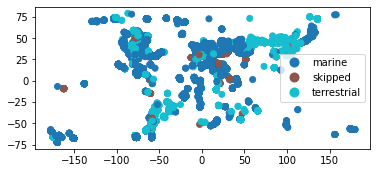

In [17]:
gpd_pbdb.plot(column='environment_broad', legend=True)  # quickly plot the geodataframe

[`geopandas.to_file`](https://geopandas.org/en/stable/docs/reference/api/geopandas.GeoDataFrame.to_file.html) makes it easy to save our data out as a shapefile.

In [18]:
gpd_pbdb.to_file('reconstructed_pbdb_data_%sMa.shp' % reconstruction_time)

/Users/nickywright/miniconda3/lib/python3.9/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
/var/folders/fm/9nwmq_gd47172_f70p3gk8nr0000gr/T/ipykernel_98042/1385639723.py:1: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  gpd_pbdb.to_file('reconstructed_pbdb_data_%sMa.shp' % reconstruction_time)


### Reconstruct coastlines

Before plotting up our data, let's reconstruct some coastlines so we broadly know where places were in the past.

In [19]:
reconstructed_coastlines = []
pygplates.reconstruct(coastlines, rotation_model, reconstructed_coastlines, 
                      reconstruction_time, export_wrap_to_dateline=True) 

### Plot


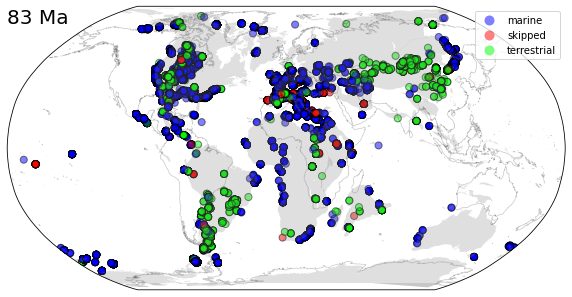

In [22]:
# --- define colours
markersize = 50
markeredgewidth = 1.5
alpha = 0.5

# plot map
fig = plt.figure(figsize=(10,6))
ax = plt.axes(projection=ccrs.Robinson())
ax.set_global()

# present-day coastlines
ax.coastlines(color='black', linewidth=0.75, resolution='50m', alpha=0.2)

# plot reconstructed coastlines
coastlines_for_plotting = []
date_line_wrapper = pygplates.DateLineWrapper()
for polygon in reconstructed_coastlines:
    wrapped_polygons = date_line_wrapper.wrap(polygon.get_reconstructed_geometry())
    for poly in wrapped_polygons:
        coastlines_for_plotting.append(
            LinearRing([(p.get_longitude(), p.get_latitude()) 
                        for p in poly.get_exterior_points()]))
ax.add_geometries(coastlines_for_plotting, ccrs.PlateCarree(), facecolor='grey', alpha=0.25) 

# ---
# plot points
gpd_pbdb.plot(ax=ax, column='environment_broad', cmap='brg', alpha=alpha, edgecolor='k', 
                   markersize=markersize, transform=ccrs.PlateCarree(), legend=True)

plt.title('%s Ma' % reconstruction_time, fontsize=20, loc='left', y=0.92)
plt.show()

### Plot reconstructed fossils through time on multiple subplots

We can use functions to help simplify repetitive tasks. 

Here, we'll use a function to: 
- reconstruct paleobiology data to *X* time
- reconstruct coastlines to *X* time
- prepare our reconstructed files for plotting
- plot our coastlines and fossil points on a specified axes

In [23]:
def reconstruct_and_plot(reconstruction_time, ax):
    
    # reconstruct fossils and coastlines
    reconstruction_time = reconstruction_time

    # reconstruct pbdb data
    reconstructed_pbdb = []
    pygplates.reconstruct(pbdb_cc, rotation_model, reconstructed_pbdb, reconstruction_time)

    gpd_pbdb = create_geodataframe_from_pbdb(reconstructed_pbdb, reconstruction_time)

    reconstructed_coastlines = []
    pygplates.reconstruct(coastlines, rotation_model, reconstructed_coastlines, 
                          reconstruction_time, export_wrap_to_dateline=True)
    
    # ---- plotting parts of the function
    # define colours
    markersize = 20
    alpha = 0.2
    
    ax.set_global()
    # plot present-day coastlines
    ax.coastlines(color='black', linewidth=0.75, resolution='50m', alpha=0.2)

    # plot reconstructed coastlines
    coastlines_for_plotting = []
    date_line_wrapper = pygplates.DateLineWrapper()
    for polygon in reconstructed_coastlines:
        wrapped_polygons = date_line_wrapper.wrap(polygon.get_reconstructed_geometry())
        for poly in wrapped_polygons:
            coastlines_for_plotting.append(
                LinearRing([(p.get_longitude(),p.get_latitude()) 
                            for p in poly.get_exterior_points()]))
    ax.add_geometries(coastlines_for_plotting, ccrs.PlateCarree(), facecolor='grey', alpha=0.25) 

    # plot pbdb points
    gpd_pbdb.plot(ax=ax, column='environment_broad', cmap='brg', alpha=alpha, edgecolor='w',
                  markersize=markersize, transform=ccrs.PlateCarree())
    
    ax.set_title('%s Ma' % reconstruction_time, fontsize=13, loc='left', y=0.92)

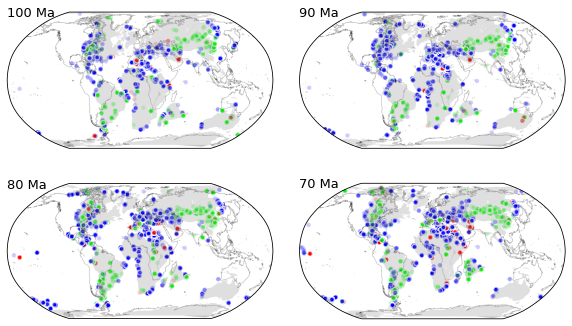

In [24]:
nrows = 2
ncols = 2

fig = plt.figure(figsize=(10, 6))

# --- first subplot
ax1 = plt.subplot(nrows, ncols, 1, projection=ccrs.Robinson())
reconstruct_and_plot(100, ax1)

# --- second subplot
ax2 = plt.subplot(nrows, ncols, 2, projection=ccrs.Robinson())
reconstruct_and_plot(90, ax2)

# --- third subplot
ax3 = plt.subplot(nrows, ncols, 3, projection=ccrs.Robinson())
reconstruct_and_plot(80, ax3)

# ---
ax4 = plt.subplot(nrows, ncols, 4, projection=ccrs.Robinson())
reconstruct_and_plot(70, ax4)

# set the spacing between subplots
plt.subplots_adjust(wspace=0.1, hspace=0.1)

plt.show()

---

## Distribution of Cenozoic gastropods

Since we have our attributes (or columns) saved for our reconstructed fossil data, we can filter the geodataframe and just plot the location of gastropods

In [25]:
# Select gastropoda based on their accepted_names
gpd_pbdb_gastropod = gpd_pbdb.loc[gpd_pbdb.accepted_names == 'Gastropoda']
gpd_pbdb_gastropod

,NAME,PLATEID1,FROMAGE,TOAGE,accepted_names,environment,environment_broad,occurrence_no,geometry,reconstruction_time
830,NaN,802,83.5,66.0,Gastropoda,foreshore,marine,40331,POINT (-76.70718 -66.46845),83
839,NaN,802,83.5,66.0,Gastropoda,foreshore,marine,40340,POINT (-76.70718 -66.46845),83
1117,NaN,813,83.6,66.0,Gastropoda,NaN,skipped,45830,POINT (-150.73288 -67.59389),83
4648,NaN,334,86.3,72.1,Gastropoda,"reef, buildup or bioherm",skipped,207290,POINT (3.66421 27.80462),83
4654,NaN,334,86.3,72.1,Gastropoda,"reef, buildup or bioherm",skipped,207328,POINT (3.66421 27.80462),83
...,...,...,...,...,...,...,...,...,...,...
35610,NaN,2039,83.6,72.1,Gastropoda,carbonate indet.,marine,1567731,POINT (-77.90055 9.73699),83
35612,NaN,2039,83.6,72.1,Gastropoda,marine indet.,marine,1567733,POINT (-77.86549 8.97544),83
35616,NaN,2039,83.6,72.1,Gastropoda,carbonate indet.,marine,1567737,POINT (-78.00757 9.31388),83
36099,NaN,202,100.5,66.0,Gastropoda,terrestrial indet.,terrestrial,1579510,POINT (-58.05396 -36.20123),83


In [26]:
# calculate the average age, based on their appearance (FROMAGE) and disappearance age (TOAGE)
gpd_pbdb_gastropod['average_age'] = (gpd_pbdb_gastropod.FROMAGE + gpd_pbdb_gastropod.TOAGE) / 2

/Users/nickywright/miniconda3/lib/python3.9/site-packages/geopandas/geodataframe.py:1351: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [27]:
gpd_pbdb_gastropod

,NAME,PLATEID1,FROMAGE,TOAGE,accepted_names,environment,environment_broad,occurrence_no,geometry,reconstruction_time,average_age
830,NaN,802,83.5,66.0,Gastropoda,foreshore,marine,40331,POINT (-76.70718 -66.46845),83,74.75
839,NaN,802,83.5,66.0,Gastropoda,foreshore,marine,40340,POINT (-76.70718 -66.46845),83,74.75
1117,NaN,813,83.6,66.0,Gastropoda,NaN,skipped,45830,POINT (-150.73288 -67.59389),83,74.80
4648,NaN,334,86.3,72.1,Gastropoda,"reef, buildup or bioherm",skipped,207290,POINT (3.66421 27.80462),83,79.20
4654,NaN,334,86.3,72.1,Gastropoda,"reef, buildup or bioherm",skipped,207328,POINT (3.66421 27.80462),83,79.20
...,...,...,...,...,...,...,...,...,...,...,...
35610,NaN,2039,83.6,72.1,Gastropoda,carbonate indet.,marine,1567731,POINT (-77.90055 9.73699),83,77.85
35612,NaN,2039,83.6,72.1,Gastropoda,marine indet.,marine,1567733,POINT (-77.86549 8.97544),83,77.85
35616,NaN,2039,83.6,72.1,Gastropoda,carbonate indet.,marine,1567737,POINT (-78.00757 9.31388),83,77.85
36099,NaN,202,100.5,66.0,Gastropoda,terrestrial indet.,terrestrial,1579510,POINT (-58.05396 -36.20123),83,83.25


### Plot

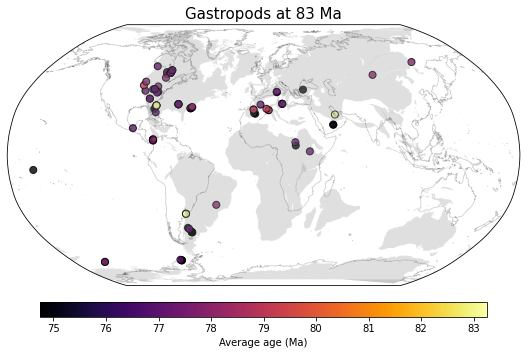

In [28]:
# --- define colours
markersize = 50

# plot map
fig = plt.figure(figsize=(10,6))
ax = plt.axes(projection=ccrs.Robinson())
ax.set_global()

# present-day coastlines
ax.coastlines(color='black', linewidth=0.75, resolution='50m', alpha=0.2)

# plot reconstructed coastlines
coastlines_for_plotting = []
date_line_wrapper = pygplates.DateLineWrapper()
for polygon in reconstructed_coastlines:
    wrapped_polygons = date_line_wrapper.wrap(polygon.get_reconstructed_geometry())
    for poly in wrapped_polygons:
        coastlines_for_plotting.append(
            LinearRing([(p.get_longitude(), p.get_latitude()) 
                        for p in poly.get_exterior_points()]))
ax.add_geometries(coastlines_for_plotting, ccrs.PlateCarree(), facecolor='grey', alpha=0.25) 

# ---
# plot pbdb points, and colour by average age column
gpd_pbdb_gastropod.plot(ax=ax, column='average_age',
                        cmap='inferno',
                        edgecolor='k',
                        markersize=markersize,
                        transform=ccrs.PlateCarree(),
                        alpha=0.8,
                        legend=True,
                        legend_kwds={'label': 'Average age (Ma)', 
                                     'shrink': 0.8, 'pad': 0.05, 'aspect': 30,
                                     'orientation': 'horizontal'})

plt.title('Gastropods at %s Ma' % reconstruction_time, fontsize=15)

plt.show()